## 1. processed_mon_data.pkl > extra_features.pkl

### (1) processed_mon_data.pkl > array code

In [23]:
import pickle

# Load the pickle file
print("Loading datafile...")
with open("/content/processed_mon_data.pkl", 'rb') as fi: # Path to processed_mon_data.pkl in Colab
    data = pickle.load(fi)

X = data[0] # 19,000 instances
y = data[1] # Array to store the site of each instance - 19,000 instances, e.g., [0, 0, 0, 0, 0, 0, ..., 94, 94, 94, 94, 94]

# X[0] ~ X[199]: label = 0
# X[200] ~ X[399]: label = 1
# ...
# X[0]: label = 0, instance_id = 0
# len(X[0]): label = 0, instance_id = 0인 데이터의 패킷 수
# X[0][0]: label = 0, instance_id = 0인 데이터의 첫 번째 패킷 [timestamp, signed_size]

X1 = [] # Array to store instances (timestamps) - 19,000 instances, e.g., [[0.0, 0.5, 3.4, ...], [0.0, 4.5, ...], [0.0, 1.5, ...], ... [... ,45.8]]
X2 = [] # Array to store instances (direction*size) - size information

for i in range(95):
  label = i
  for j in range(200):
    time_seq = []
    size_seq = []
    length = len(X[i*200+j])
    for k in range(length):
      time_seq.append(X[i*200+j][k][0])
      size_seq.append(X[i*200+j][k][1])
    X1.append(time_seq)
    X2.append(size_seq)

size = len(X1)

print(f'Total samples: {size}') # Output: 19000

Loading datafile...
Total samples: 19000


##### X1, X2, y를 하나의 dataframe으로 변환

In [24]:
import pandas as pd
import numpy as np

df = pd.DataFrame({'time': X1, 'size': X2, 'label': y})

In [25]:
print(df)

                                                    time  \
0      [0.0, 4.440892098500626e-16, 0.004500000000000...   
1      [0.0, 4.440892098500626e-16, 0.020000000000000...   
2      [0.0, 0.0, 0.0029999999999992255, 0.0029999999...   
3      [0.0, 0.0, 0.0045000000000001705, 0.0045000000...   
4      [0.0, 1.3877787807814457e-17, 0.113, 0.1225000...   
...                                                  ...   
18995  [0.0, 0.0, 0.08199999999999999, 0.15, 0.232, 0...   
18996  [0.0, 2.7755575615628914e-17, 0.10000000000000...   
18997  [0.0, 4.440892098500626e-16, 0.067500000000000...   
18998  [0.0, 0.0, 0.008999999999999453, 0.00899999999...   
18999  [0.0, 0.0, 0.009500000000000064, 0.01300000000...   

                                                    size  label  
0      [512.0, -512.0, -512.0, -512.0, -512.0, -512.0...      0  
1      [-512.0, -512.0, -512.0, -512.0, -512.0, -512....      0  
2      [-512.0, 512.0, -512.0, -512.0, -512.0, -512.0...      0  
3      [-512.0,

### (2) Feature Extraction

- total_transmission_time(총 전송 시간)
- std_inter_packet_time(패킷 간 시간 간격의 표준편차)
- avg_outgoing_burst_size(송신 버스트 평균 크기)
- num_outgoing_packets(송신 패킷의 총 개수)
- avg_incoming_burst_size(수신 버스트 평균 크기)
- cumul_packets_30pct(전체 시간의 30% 시점까지의 패킷 수)
- cumul_packets_10pct(전체 시간의 10% 시점까지의 패킷 수)
- incoming_order_skew(수신 패킷 순서 목록의 왜도)
- outgoing_first_30(세션 첫 30개 패킷 중 송신 비율)
- outgoing_order_skew(송신 패킷 순서 목록의 왜도)
- cumul_max(누적 패킷 시퀀스의 최대)
- bigram_OO (방향 N-gram 빈도 (N=2, Bigram))
- avg_incoming_order_first_30(처음 30 패킷의 수신 패킷 순서 목록의 평균)
- avg_outgoing_order_first_30(처음 30 패킷의 송신 패킷 순서 목록의 평균)
- num_incoming_first_30(처음 30 패킷의 수신 패킷 수)
- incoming_packet_ratio(수신 패킷 비율)
- outgoing_packet_ratio(송신 패킷 비율)

In [20]:
import numpy as np
from scipy import stats

def extract_all_features(df):
    time = np.array(df['time'])
    size = np.array(df['size'])

    # The sequence of direction
    direction = np.sign(size)

    # Total packet count
    total_packets = len(time)

    # Initialize features (UnboundLocalError 방지)
    total_transmission_time = 0.0
    std_inter_packet_time = 0.0
    avg_outgoing_burst_size = 0.0
    avg_incoming_burst_size = 0.0
    num_outgoing_packets = 0
    incoming_packet_ratio = 0.0
    outgoing_packet_ratio = 0.0
    cumul_packets_10pct = 0
    cumul_packets_30pct = 0
    incoming_order_skew = 0.0
    outgoing_order_skew = 0.0
    cumul_max = 0
    bigram_OO = 0.0
    num_incoming_first_30 = 0
    outgoing_first_30 = 0.0
    avg_incoming_order_first_30 = 0.0
    avg_outgoing_order_first_30 = 0.0

    # 1. total_transmission_time (총 전송 시간)
    total_transmission_time = time[-1]

    # 2. std_inter_packet_time (패킷 간 시간 간격의 표준편차)
    inter_packet_times = np.diff(time)
    std_inter_packet_time = np.std(inter_packet_times) if len(inter_packet_times) > 0 else 0

    # 3 & 5. avg_outgoing_burst_size, avg_incoming_burst_size (버스트 계산)
    if total_packets > 0:
        direction_changes = np.where(np.diff(direction) != 0)[0] + 1
        burst_starts = np.insert(direction_changes, 0, 0)
        total_bursts = len(burst_starts)
        burst_lengths = np.diff(np.append(burst_starts, total_packets))
        burst_directions = direction[burst_starts]
        outgoing_burst_lengths = burst_lengths[burst_directions == 1]
        incoming_burst_lengths = burst_lengths[burst_directions == -1]

        if len(outgoing_burst_lengths) > 0:
            avg_outgoing_burst_size = np.mean(outgoing_burst_lengths)

        if len(incoming_burst_lengths) > 0:
            avg_incoming_burst_size = np.mean(incoming_burst_lengths)

    # 4. num_outgoing_packets (송신 패킷의 총 개수)
    num_outgoing_packets = np.sum(direction == 1)

    # 16. incoming_packet_ratio (수신 패킷 비율)
    num_incoming_packets = np.sum(direction == -1)
    incoming_packet_ratio = num_incoming_packets / total_packets

    # 17. outgoing_packet_ratio (송신 패킷 비율)
    outgoing_packet_ratio = num_outgoing_packets / total_packets

    # 6 & 7. cumul_packets_10pct, cumul_packets_30pct (누적 패킷)
    max_time = max(time) if total_packets > 0 else 0
    max_time_safe = max_time if max_time > 0 else 1.0 # 0으로 나누기 방지

    time_threshold_10 = 0.10 * max_time
    time_threshold_30 = 0.30 * max_time

    cumul_packets_10pct = sum(1 for t in time if t <= time_threshold_10)
    cumul_packets_30pct = sum(1 for t in time if t <= time_threshold_30)

    # 8. incoming_order_skew (수신 패킷 순서 목록의 왜도)
    incoming_order = np.where(direction == -1)[0]
    if len(incoming_order) > 1:
        incoming_order_skew = stats.skew(incoming_order)
    else:
        incoming_order_skew = 0

    # 10. outgoing_order_skew (송신 패킷 순서 목록의 왜도)
    outgoing_order = np.where(direction == 1)[0]
    if len(outgoing_order) > 1:
        outgoing_order_skew = stats.skew(outgoing_order)
    else:
        outgoing_order_skew = 0

    # 11. cumul_max (누적 패킷 시퀀스의 최대) (방향의 누적 합(csum)의 최대값으로 해석)
    csum_seq = np.cumsum(direction)
    cumul_max = np.max(csum_seq)

    # 12. bigram_OO (방향 Bigram 빈도 - OO)
    total_bigrams = total_packets - 1
    if total_bigrams > 0:
        oo_count = sum(1 for i in range(total_bigrams) if direction[i] == -1 and direction[i+1] == -1)
        bigram_OO = oo_count / total_bigrams

    # first 30 packets
    first_30_directions = direction[:30]
    total_first_30 = len(first_30_directions)

    if total_first_30 > 0:
        # 15. num_incoming_first_30 (처음 30 패킷의 수신 패킷 수)
        num_incoming_first_30 = sum(1 for d in first_30_directions if d == -1)

        # 9. outgoing_first_30 (세션 첫 30개 패킷 중 송신 비율)
        num_out_30 = sum(1 for d in first_30_directions if d == 1)
        outgoing_first_30 = num_out_30 / total_first_30

        # 13. savg_incoming_order_first_30 (처음 30 패킷의 수신 패킷 순서 목록의 평균)
        in_order_indices_30 = [i for i, d in enumerate(first_30_directions) if d == -1]
        if in_order_indices_30:
            avg_incoming_order_first_30 = np.mean(in_order_indices_30)

        # 14. avg_outgoing_order_first_30 (처음 30 패킷의 송신 패킷 순서 목록의 평균)
        out_order_indices_30 = [i for i, d in enumerate(first_30_directions) if d == 1]
        if out_order_indices_30:
            avg_outgoing_order_first_30 = np.mean(out_order_indices_30)

    return pd.Series({
        'total_transmission_time': total_transmission_time,
        'std_inter_packet_time': std_inter_packet_time,
        'avg_outgoing_burst_size': avg_outgoing_burst_size,
        'avg_incoming_burst_size': avg_incoming_burst_size,
        'num_outgoing_packets': num_outgoing_packets,
        'incoming_packet_ratio': incoming_packet_ratio,
        'outgoing_packet_ratio': outgoing_packet_ratio,
        'cumul_packets_10pct': cumul_packets_10pct,
        'cumul_packets_30pct': cumul_packets_30pct,
        'outgoing_order_skew': outgoing_order_skew,
        'incoming_order_skew': incoming_order_skew,
        'cumul_max': cumul_max,
        'bigram_OO': bigram_OO,
        'num_incoming_first_30': num_incoming_first_30,
        'outgoing_first_30': outgoing_first_30,
        'avg_incoming_order_first_30': avg_incoming_order_first_30,
        'avg_outgoing_order_first_30': avg_outgoing_order_first_30
    })

# axis=1: DataFrame의 각 행(row)에 함수를 적용
features = df.apply(extract_all_features, axis=1)

print(features)

       total_transmission_time  std_inter_packet_time  \
0                     6.867427               0.033406   
1                     6.560100               0.061620   
2                     9.721923               0.048246   
3                     9.673480               0.103539   
4                     8.870500               0.065075   
...                        ...                    ...   
18995                17.824500               0.036371   
18996                15.577000               0.021270   
18997                14.928000               0.016300   
18998                19.875503               0.044860   
18999                13.764000               0.017962   

       avg_outgoing_burst_size  avg_incoming_burst_size  num_outgoing_packets  \
0                     1.962963                13.777778                 106.0   
1                     1.928571                26.857143                  27.0   
2                     2.717949                27.179487                 

##### correlation analysis를 위해 feature dataframe과 label을 하나의 파일로 저장

In [21]:
import pandas as pd
import numpy as np
import pickle

mon_features = pd.concat([features, df['label']], axis=1)
print(mon_features.head())

mon_features.to_pickle('/content/extra_mon_features.pkl')

   total_transmission_time  std_inter_packet_time  avg_outgoing_burst_size  \
0                 6.867427               0.033406                 1.962963   
1                 6.560100               0.061620                 1.928571   
2                 9.721923               0.048246                 2.717949   
3                 9.673480               0.103539                 2.320000   
4                 8.870500               0.065075                 1.685714   

   avg_incoming_burst_size  num_outgoing_packets  incoming_packet_ratio  \
0                13.777778                 106.0               0.875294   
1                26.857143                  27.0               0.933002   
2                27.179487                 106.0               0.909091   
3                35.307692                  58.0               0.940574   
4                28.472222                  59.0               0.945572   

   outgoing_packet_ratio  cumul_packets_10pct  cumul_packets_30pct  \
0         

## 2. processed_unmon_data.pkl > unmon_features.pkl

### (1) processed_unmon_data.pkl > array code

In [1]:
import pickle

TOTAL_URLS = 19000  # total number in the dataset

# Load 19,000 unmon pickle file
print("Loading datafile...")
with open('/content/processed_unmon_data.pkl', 'rb') as f:  # Path to processed_unmon_data.pkl in Colab
    data = pickle.load(f)

size = len(data[0])
print(f'Total samples: {size}')

X = data[0] # 19,000 instances
y = data[1] # Array to store the site of each instance - 19,000 instances, e.g., [-1, -1, -1, ..., -1, -1, -1]

# X[0]: instance_id = 0
# len(X[0]): instance_id = 0인 데이터의 패킷 수
# X[0][0]: instance_id = 0인 데이터의 첫 번째 패킷 [timestamp, signed_size]

X1 = [] # Array to store instances (timestamps) - 10,000 instances, e.g., [[0.0, 0.5, 3.4, ...], [0.0, 4.5, ...], [0.0, 1.5, ...], ... [... ,45.8]]
X2 = [] # Array to store instances (direction*size) - size information

for i in range(TOTAL_URLS):
    size_seq = []
    time_seq = []
    for c in X[i]:
        time_seq.append(c[0])
        size_seq.append(c[1]) # In the pickle file, there is no size information, so the conversion code is set to multiply by 512 uniformly.
    X1.append(time_seq)
    X2.append(size_seq)


print(len(X1)) # Print the length of X1

Loading datafile...
Total samples: 19000
19000


##### X1, X2, monitored label, y를 하나의 dataframe으로 변환

In [3]:
import pandas as pd
import numpy as np

df = pd.DataFrame({'time': X1, 'size': X2, 'label': y})
print(df)

                                                    time  \
0      [0.0, 0.0, 0.0039999999999995595, 0.0054999999...   
1      [0.0, 0.0, 0.09449999999999997, 0.205, 0.2995,...   
2      [0.0, 0.0, 0.0004999999999997229, 0.0255000000...   
3      [0.0, 0.0, 0.0004999999999997229, 0.0110000000...   
4      [0.0, 0.0, 0.0009999999999994458, 0.0049999999...   
...                                                  ...   
18995  [0.0, 1.3877787807814457e-17, 0.08850000000000...   
18996  [0.0, 0.0, 0.0, 0.005499999999999616, 0.009999...   
18997  [0.0, 0.0, 0.07500000000000001, 0.127, 0.202, ...   
18998  [0.0, 0.0, 0.0004999999999997229, 0.0039999999...   
18999  [0.0, 0.0, 0.006000000000000227, 0.01449999999...   

                                                    size  label  
0      [-512.0, -512.0, -512.0, -512.0, -512.0, -512....     -1  
1      [-512.0, 512.0, 512.0, -512.0, -512.0, 512.0, ...     -1  
2      [-512.0, -512.0, -512.0, -512.0, -512.0, -512....     -1  
3      [-512.0,

### (2) Feature Extraction

- total_transmission_time(총 전송 시간)
- std_inter_packet_time(패킷 간 시간 간격의 표준편차)
- avg_outgoing_burst_size(송신 버스트 평균 크기)
- num_outgoing_packets(송신 패킷의 총 개수)
- avg_incoming_burst_size(수신 버스트 평균 크기)
- cumul_packets_30pct(전체 시간의 30% 시점까지의 패킷 수)
- cumul_packets_10pct(전체 시간의 10% 시점까지의 패킷 수)
- incoming_order_skew(수신 패킷 순서 목록의 왜도)
- outgoing_first_30(세션 첫 30개 패킷 중 송신 비율)
- outgoing_order_skew(송신 패킷 순서 목록의 왜도)
- cumul_max(누적 패킷 시퀀스의 최대)
- bigram_OO (방향 N-gram 빈도 (N=2, Bigram))
- avg_incoming_order_first_30(처음 30 패킷의 수신 패킷 순서 목록의 평균)
- avg_outgoing_order_first_30(처음 30 패킷의 송신 패킷 순서 목록의 평균)
- num_incoming_first_30(처음 30 패킷의 수신 패킷 수)
- incoming_packet_ratio(수신 패킷 비율)
- outgoing_packet_ratio(송신 패킷 비율)

In [4]:
import numpy as np
from scipy import stats

def extract_all_features(df):
    time = np.array(df['time'])
    size = np.array(df['size'])

    # The sequence of direction
    direction = np.sign(size)

    # Total packet count
    total_packets = len(time)

     # Initialize features (UnboundLocalError 방지)
    total_transmission_time = 0.0
    std_inter_packet_time = 0.0
    avg_outgoing_burst_size = 0.0
    avg_incoming_burst_size = 0.0
    num_outgoing_packets = 0
    incoming_packet_ratio = 0.0
    outgoing_packet_ratio = 0.0
    cumul_packets_10pct = 0
    cumul_packets_30pct = 0
    incoming_order_skew = 0.0
    outgoing_order_skew = 0.0
    cumul_max = 0
    bigram_OO = 0.0
    num_incoming_first_30 = 0
    outgoing_first_30 = 0.0
    avg_incoming_order_first_30 = 0.0
    avg_outgoing_order_first_30 = 0.0

    # 1. total_transmission_time (총 전송 시간)
    total_transmission_time = time[-1]

    # 2. std_inter_packet_time (패킷 간 시간 간격의 표준편차)
    inter_packet_times = np.diff(time)
    std_inter_packet_time = np.std(inter_packet_times) if len(inter_packet_times) > 0 else 0

    # 3 & 5. avg_outgoing_burst_size, avg_incoming_burst_size (버스트 계산)
    if total_packets > 0:
        direction_changes = np.where(np.diff(direction) != 0)[0] + 1
        burst_starts = np.insert(direction_changes, 0, 0)
        total_bursts = len(burst_starts)
        burst_lengths = np.diff(np.append(burst_starts, total_packets))
        burst_directions = direction[burst_starts]
        outgoing_burst_lengths = burst_lengths[burst_directions == 1]
        incoming_burst_lengths = burst_lengths[burst_directions == -1]

        if len(outgoing_burst_lengths) > 0:
            avg_outgoing_burst_size = np.mean(outgoing_burst_lengths)

        if len(incoming_burst_lengths) > 0:
            avg_incoming_burst_size = np.mean(incoming_burst_lengths)

    # 4. num_outgoing_packets (송신 패킷의 총 개수)
    num_outgoing_packets = np.sum(direction == 1)

    # 16. incoming_packet_ratio (수신 패킷 비율)
    num_incoming_packets = np.sum(direction == -1)
    incoming_packet_ratio = num_incoming_packets / total_packets

    # 17. outgoing_packet_ratio (송신 패킷 비율)
    outgoing_packet_ratio = num_outgoing_packets / total_packets

    # 6 & 7. cumul_packets_10pct, cumul_packets_30pct (누적 패킷)
    max_time = max(time) if total_packets > 0 else 0
    max_time_safe = max_time if max_time > 0 else 1.0 # 0으로 나누기 방지

    time_threshold_10 = 0.10 * max_time
    time_threshold_30 = 0.30 * max_time

    cumul_packets_10pct = sum(1 for t in time if t <= time_threshold_10)
    cumul_packets_30pct = sum(1 for t in time if t <= time_threshold_30)

    # 8. incoming_order_skew (수신 패킷 순서 목록의 왜도)
    incoming_order = np.where(direction == -1)[0]
    if len(incoming_order) > 1:
        incoming_order_skew = stats.skew(incoming_order)
    else:
        incoming_order_skew = 0

    # 10. outgoing_order_skew (송신 패킷 순서 목록의 왜도)
    outgoing_order = np.where(direction == 1)[0]
    if len(outgoing_order) > 1:
        outgoing_order_skew = stats.skew(outgoing_order)
    else:
        outgoing_order_skew = 0

    # 11. cumul_max (누적 패킷 시퀀스의 최대) (방향의 누적 합(csum)의 최대값으로 해석)
    csum_seq = np.cumsum(direction)
    cumul_max = np.max(csum_seq)

    # 12. bigram_OO (방향 Bigram 빈도 - OO)
    total_bigrams = total_packets - 1
    if total_bigrams > 0:
        oo_count = sum(1 for i in range(total_bigrams) if direction[i] == -1 and direction[i+1] == -1)
        bigram_OO = oo_count / total_bigrams

    # --- 첫 30개 패킷 관련 피처 ---
    first_30_directions = direction[:30]
    total_first_30 = len(first_30_directions)

    if total_first_30 > 0:
        # 15. num_incoming_first_30 (처음 30 패킷의 수신 패킷 수)
        num_incoming_first_30 = sum(1 for d in first_30_directions if d == -1)

        # 9. outgoing_first_30 (세션 첫 30개 패킷 중 송신 비율)
        num_out_30 = sum(1 for d in first_30_directions if d == 1)
        outgoing_first_30 = num_out_30 / total_first_30

        # 13. savg_incoming_order_first_30 (처음 30 패킷의 수신 패킷 순서 목록의 평균)
        in_order_indices_30 = [i for i, d in enumerate(first_30_directions) if d == -1]
        if in_order_indices_30:
            avg_incoming_order_first_30 = np.mean(in_order_indices_30)

        # 14. avg_outgoing_order_first_30 (처음 30 패킷의 송신 패킷 순서 목록의 평균)
        out_order_indices_30 = [i for i, d in enumerate(first_30_directions) if d == 1]
        if out_order_indices_30:
            avg_outgoing_order_first_30 = np.mean(out_order_indices_30)

    return pd.Series({
        'total_transmission_time': total_transmission_time,
        'std_inter_packet_time': std_inter_packet_time,
        'avg_outgoing_burst_size': avg_outgoing_burst_size,
        'avg_incoming_burst_size': avg_incoming_burst_size,
        'num_outgoing_packets': num_outgoing_packets,
        'incoming_packet_ratio': incoming_packet_ratio,
        'outgoing_packet_ratio': outgoing_packet_ratio,
        'cumul_packets_10pct': cumul_packets_10pct,
        'cumul_packets_30pct': cumul_packets_30pct,
        'outgoing_order_skew': outgoing_order_skew,
        'incoming_order_skew': incoming_order_skew,
        'cumul_max': cumul_max,
        'bigram_OO': bigram_OO,
        'num_incoming_first_30': num_incoming_first_30,
        'outgoing_first_30': outgoing_first_30,
        'avg_incoming_order_first_30': avg_incoming_order_first_30,
        'avg_outgoing_order_first_30': avg_outgoing_order_first_30
    })

# axis=1: DataFrame의 각 행(row)에 함수를 적용
features = df.apply(extract_all_features, axis=1)

print(features)

       total_transmission_time  std_inter_packet_time  \
0                     5.548500               0.116785   
1                    11.884500               0.018515   
2                    13.590207               0.160838   
3                     4.413435               0.005753   
4                    53.405500               0.345755   
...                        ...                    ...   
18995                37.410611               0.397146   
18996                47.524500               0.151112   
18997                 5.132000               0.142155   
18998                 5.690500               0.026630   
18999                 9.624537               0.016456   

       avg_outgoing_burst_size  avg_incoming_burst_size  num_outgoing_packets  \
0                     1.450000                 4.809524                  29.0   
1                     2.391304                84.344086                 220.0   
2                     2.500000               133.500000                 

##### correlation analysis를 위해 feature dataframe과 label을 하나의 파일로 저장

In [6]:
import pandas as pd
import numpy as np
import pickle

mon_features = pd.concat([features, df['label']], axis=1)
print(mon_features.head())

mon_features.to_pickle('/content/extra_unmon_features.pkl')

   total_transmission_time  std_inter_packet_time  avg_outgoing_burst_size  \
0                 5.548500               0.116785                 1.450000   
1                11.884500               0.018515                 2.391304   
2                13.590207               0.160838                 2.500000   
3                 4.413435               0.005753                 2.320388   
4                53.405500               0.345755                 6.222222   

   avg_incoming_burst_size  num_outgoing_packets  incoming_packet_ratio  \
0                 4.809524                  29.0               0.776923   
1                84.344086                 220.0               0.972718   
2               133.500000                   5.0               0.981618   
3                59.097087                 239.0               0.962219   
4                83.000000                 112.0               0.933689   

   outgoing_packet_ratio  cumul_packets_10pct  cumul_packets_30pct  \
0         

## 3. Correlation analysis

extra_mon_features.pkl, extra_unmon_features.pkl 불러와서 하나의 dataframe으로 합치기

In [7]:
import pandas as pd

mon_df = pd.read_pickle('/content/extra_mon_features.pkl')
unmon_df = pd.read_pickle('/content/extra_unmon_features.pkl')

features_df = pd.concat([mon_df, unmon_df], ignore_index=True)

print(features_df)
features_df.to_pickle('/content/extra_features.pkl')

       total_transmission_time  std_inter_packet_time  \
0                     6.867427               0.033406   
1                     6.560100               0.061620   
2                     9.721923               0.048246   
3                     9.673480               0.103539   
4                     8.870500               0.065075   
...                        ...                    ...   
37995                37.410611               0.397146   
37996                47.524500               0.151112   
37997                 5.132000               0.142155   
37998                 5.690500               0.026630   
37999                 9.624537               0.016456   

       avg_outgoing_burst_size  avg_incoming_burst_size  num_outgoing_packets  \
0                     1.962963                13.777778                 106.0   
1                     1.928571                26.857143                  27.0   
2                     2.717949                27.179487                 

Correlation matrix & Heatmap

                             total_transmission_time  std_inter_packet_time  \
total_transmission_time                     1.000000               0.416729   
std_inter_packet_time                       0.416729               1.000000   
avg_outgoing_burst_size                     0.093522              -0.015057   
avg_incoming_burst_size                    -0.058254              -0.063731   
num_outgoing_packets                        0.292142              -0.135585   
incoming_packet_ratio                      -0.056143              -0.257606   
outgoing_packet_ratio                       0.056143               0.257606   
cumul_packets_10pct                         0.413467               0.019982   
cumul_packets_30pct                         0.496208              -0.063010   
outgoing_order_skew                         0.004356               0.036271   
incoming_order_skew                         0.098702              -0.103451   
cumul_max                                   0.038129

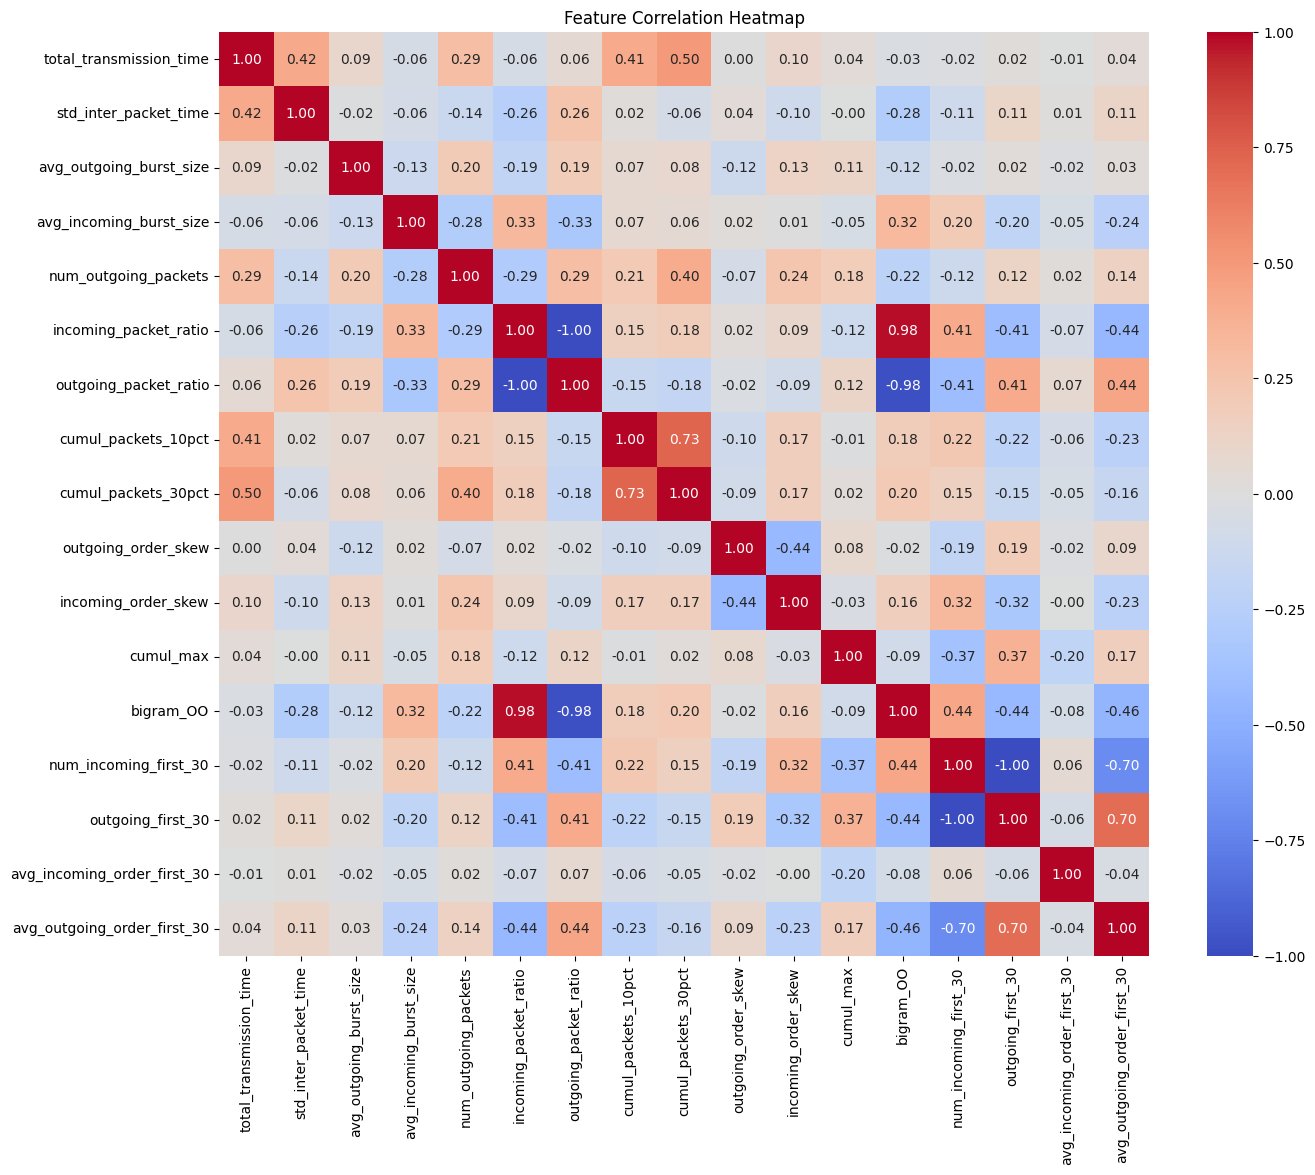

In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Correlation matrix
y_columns = ['label']
corr_matrix = features_df.drop(columns=y_columns, errors='ignore').corr()
print(corr_matrix)

# Heatmap
plt.figure(figsize=(15, 12))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Feature Correlation Heatmap')
plt.show()

feature와 label에 대한 feature importance (Random Forest 이용)


--- Feature Importances (from Random Forest) ---
total_transmission_time        0.110067
std_inter_packet_time          0.103090
cumul_packets_30pct            0.101779
cumul_packets_10pct            0.092258
avg_incoming_burst_size        0.086125
num_outgoing_packets           0.064474
incoming_order_skew            0.059413
outgoing_order_skew            0.058335
avg_outgoing_burst_size        0.056766
bigram_OO                      0.052595
incoming_packet_ratio          0.050091
outgoing_packet_ratio          0.049990
avg_incoming_order_first_30    0.031740
avg_outgoing_order_first_30    0.027987
num_incoming_first_30          0.020114
outgoing_first_30              0.019258
cumul_max                      0.015918
dtype: float64


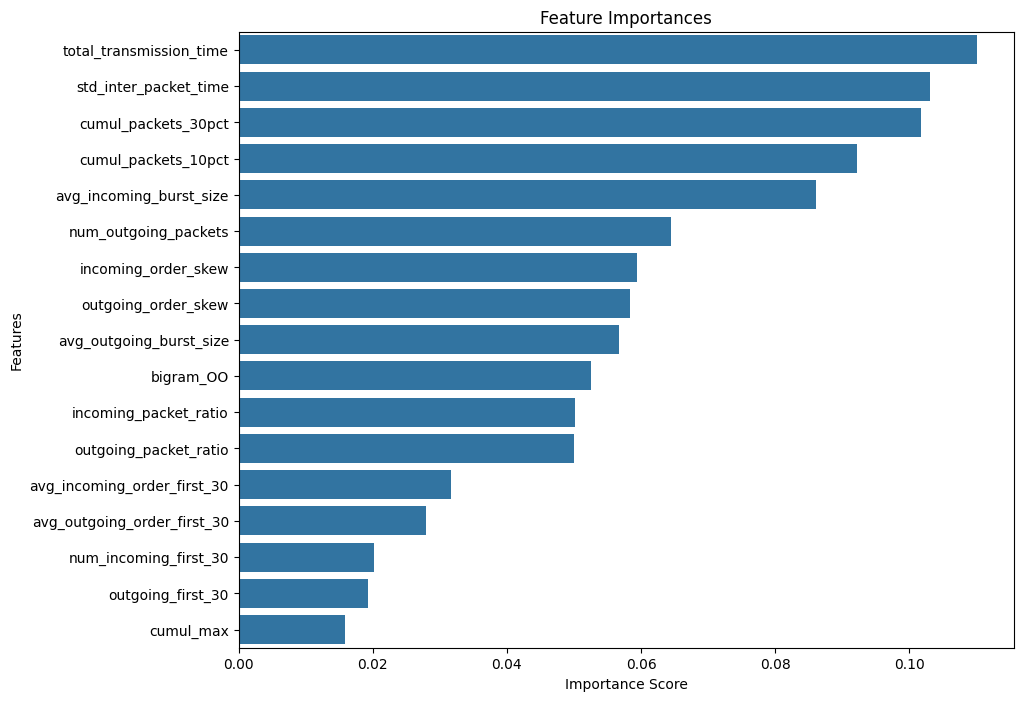

In [9]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns

y_columns = ['label']
X = features_df.drop(columns=y_columns, errors='ignore')
y = features_df['label']

model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X, y)

importances = model.feature_importances_

feature_importances = pd.Series(importances, index=X.columns)

sorted_importances = feature_importances.sort_values(ascending=False)

print("\n--- Feature Importances (from Random Forest) ---")
print(sorted_importances)

plt.figure(figsize=(10, 8))
sns.barplot(x=sorted_importances, y=sorted_importances.index)
plt.title('Feature Importances')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.show()